In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, f1_score
from sklearn.calibration import calibration_curve, CalibrationDisplay

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from boruta import BorutaPy 

from sklearn.datasets import load_digits

import matplotlib.ticker as mtick
import seaborn as sns

sns.set()

/Applications/Anaconda/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('ift6758/data/extracted/shot_goal_20151007_20210707.csv')
df = df.apply(pd.to_numeric, args=('ignore',))

df = df[
        (df['season'].isin([20152016, 20162017, 20172018, 20182019])) & (
                    df['gameType'] == 'R') & (
                    df['periodType'] != 'SHOOTOUT')]

df_dropped = df[df['season']!=20192020]

df_dropped = df_dropped[['isGoal', 'speedOfChangeOfAngle', 'speed', 'changeOfAngleFromPrev', 'rebound', 'distanceFromPrev'
                          , 'secondsSincePrev', 'prevAngleWithGoal', 'prevY', 'prevX', 'prevEvent', 'prevSecondsSinceStart',
                          'angleWithGoal', 'distanceToGoal', 'x', 'y', 'emptyNet', 'strength', 'secondsSinceStart', 'shotType']]

df_dropped['emptyNet'] = df_dropped['emptyNet'].fillna(0)
df_dropped['strength'] = df_dropped['strength'].fillna('Even')

dummy_object = pd.get_dummies(df_dropped[['strength', 'shotType', 'prevEvent']])
df_dropped = df_dropped.merge(dummy_object, left_index=True, right_index=True)
df_dropped = df_dropped.drop(labels = ['strength', 'shotType', 'prevEvent'], axis = 1)

df_dropped = df_dropped.dropna(how='any')

#non standardized data
train, test = train_test_split(df_dropped, test_size=0.2, random_state=42)
print(train.shape)
print(test.shape)

x = train[df_dropped.columns.drop(labels = 'isGoal')].to_numpy().reshape(-1, 35)

y = train['isGoal'].to_numpy()

x_test = test[df_dropped.columns.drop(labels = 'isGoal')].to_numpy().reshape(-1, 35)

y_test = test['isGoal'].to_numpy()

x, y = RandomUnderSampler(random_state=42).fit_resample(x, y)

print(x.shape)
print(x_test.shape)
print(y_test.shape)

(246966, 36)
(61742, 36)
(45410, 35)
(61742, 35)
(61742,)


In [3]:
RF = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state = 42) 

In [4]:
features = BorutaPy(RF, n_estimators='auto', verbose=2, random_state=1)

In [5]:
features.fit(x,y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	27
Tentative: 	3
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	27
Tentative: 	3
Rejected: 	5
Iteration: 	14 / 100
Confirmed: 	27
Tentative: 	2
Rejected: 	6
Iteration: 	15 / 100
Confirmed: 	27
Tentative: 	2
Rejected: 	6
Iteration: 	16 / 100
Confirmed: 	27
Tentative: 	2
Rejected: 	6
I

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=149, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x108B92E40),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x108B92E40,
         verbose=2)

In [75]:
features.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True, False,  True, False,
        True,  True, False,  True, False, False,  True, False])

In [76]:
features.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       5, 1, 3, 1, 7, 1, 1, 9, 1, 6, 7, 1, 4])

In [6]:
x_new = features.transform(x)
x_new_test = features.transform(x_test)

In [60]:
params = {
 'bootstrap' : [True, False],
 'max_features' : ['sqrt', 'log2'],
 'max_depth' : [5, 10 , 15 , 20, 25], 
 'min_samples_split' : [2, 5, 10, 15, 20, 25, 30], 
 'min_samples_leaf' : [1, 2, 5, 10, 15, 20, 25, 30],
 'n_estimators': [300, 500, 700, 900, 1200, 1500, 1700, 2000] 
}

In [61]:
RF1 = RandomForestClassifier(n_jobs=-1, random_state = 42) 

In [62]:
BestRF = RandomizedSearchCV(RF1, param_distributions = params, n_iter=15, scoring='roc_auc', refit=True, random_state = 42)

In [63]:
BestRF.fit(x_new,y)

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=15,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15,
                                                             20, 25, 30],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              25, 30],
                                        'n_estimators': [300, 500, 700, 900,
                                                         1200, 1500, 1700,
                                                         2000]},
                   random_state=42, scoring='roc_auc')

In [64]:
BestRF.best_params_

{'n_estimators': 1500,
 'min_samples_split': 2,
 'min_samples_leaf': 15,
 'max_features': 'log2',
 'max_depth': 15,
 'bootstrap': False}

In [66]:
pd.DataFrame(BestRF.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,108.710248,5.423411,2.007385,0.229805,1700,25,2,sqrt,20,False,"{'n_estimators': 1700, 'min_samples_split': 25...",0.832705,0.826714,0.823102,0.828641,0.830832,0.828399,0.003329,4
1,18.810336,0.222606,0.737073,0.009034,1200,10,30,log2,5,True,"{'n_estimators': 1200, 'min_samples_split': 10...",0.816503,0.814836,0.813075,0.816341,0.820306,0.816212,0.002391,11
2,83.471276,2.999694,1.369394,0.074760,1700,5,1,sqrt,10,False,"{'n_estimators': 1700, 'min_samples_split': 5,...",0.829461,0.825328,0.822501,0.827767,0.829681,0.826948,0.002715,6
3,40.433770,0.701695,1.216227,0.036896,2000,20,15,log2,5,False,"{'n_estimators': 2000, 'min_samples_split': 20...",0.814977,0.814127,0.812046,0.815136,0.819260,0.815109,0.002349,14
4,84.259058,10.241749,1.538368,0.417006,1700,10,25,sqrt,10,False,"{'n_estimators': 1700, 'min_samples_split': 10...",0.829237,0.825011,0.822301,0.827042,0.829284,0.826575,0.002659,8
5,16.826757,0.791047,0.346780,0.004091,500,30,30,log2,10,False,"{'n_estimators': 500, 'min_samples_split': 30,...",0.827362,0.824210,0.821095,0.826034,0.828521,0.825444,0.002605,10
6,12.103857,1.474129,0.454146,0.019009,700,10,1,log2,5,True,"{'n_estimators': 700, 'min_samples_split': 10,...",0.816228,0.814886,0.812527,0.816167,0.819998,0.815961,0.002423,13
7,21.733894,1.180962,0.559727,0.039288,700,2,30,log2,25,True,"{'n_estimators': 700, 'min_samples_split': 2, ...",0.832077,0.827034,0.823469,0.828565,0.830682,0.828366,0.002998,5
8,27.546322,2.152687,0.470972,0.006163,700,20,10,sqrt,10,False,"{'n_estimators': 700, 'min_samples_split': 20,...",0.829108,0.825174,0.822550,0.827346,0.829518,0.826739,0.002596,7
9,41.234591,1.248869,0.669803,0.008246,700,20,15,sqrt,25,False,"{'n_estimators': 700, 'min_samples_split': 20,...",0.832566,0.826684,0.823282,0.828426,0.831258,0.828443,0.003306,3


In [70]:
#Predictions 
y_pred = BestRF.predict(x_new_test)
score_prob = BestRF.predict_proba(x_new_test)[:, 1]

#compute accuracy and f1-score
print(f'accuracy with 10 selected features with f-classif method: {accuracy_score(y_test, y_pred)}')
print(f'f1 score with 10 selected features with f-classif method: {f1_score(y_test, y_pred)}')

accuracy with 10 selected features with f-classif method: 0.740711347219073
f1 score with 10 selected features with f-classif method: 0.3390992032365933


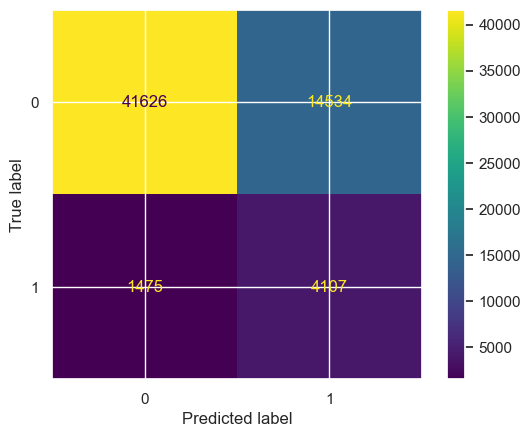

In [71]:
#confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

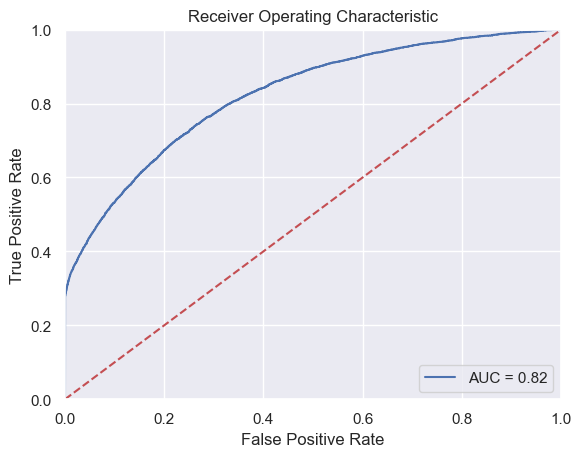

In [72]:
#plot ROC + AUC score
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

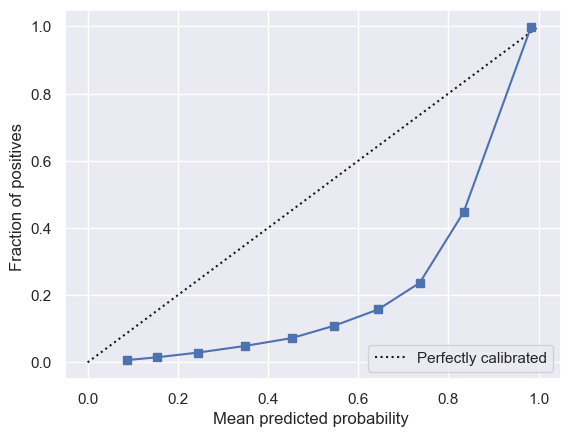

In [73]:
#plot calibration curve 
prob_true, prob_pred = calibration_curve(y_test, score_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob).plot()
plt.show()

SVM 

In [7]:
svm = svm.SVC(random_state = 42)

In [8]:
params = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              } 

In [9]:
BestSVM = RandomizedSearchCV(svm, param_distributions = params, n_iter=15, scoring='roc_auc', refit=True, random_state = 42)

In [ ]:
BestSVM.fit(x_new,y)

In [ ]:
BestRF.best_params_

In [ ]:
#Predictions 
y_pred = BestRF.predict(x_new_test)
score_prob = BestRF.predict_proba(x_new_test)[:, 1]

#compute accuracy and f1-score
print(f'accuracy with 10 selected features with f-classif method: {accuracy_score(y_test, y_pred)}')
print(f'f1 score with 10 selected features with f-classif method: {f1_score(y_test, y_pred)}')

In [ ]:
#confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

In [ ]:
#plot ROC + AUC score
fpr, tpr, threshold = metrics.roc_curve(y_test, score_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#plot calibration curve 
prob_true, prob_pred = calibration_curve(y_test, score_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob).plot()
plt.show()